<a href="https://colab.research.google.com/github/candysax/rea_neuro_ns1/blob/main/neuron_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

<h2 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

---

В этом ноутбуке мы научимся писать свои нейросети на фреймворке PyTorch, конкретно -- рассмотрим, как написать свой нейрон с разными функциями потерь и рассмотрим его работу на конкретных датасетах.

<h3 style="text-align: center;"><b>Компоненты нейросети</b></h3>

Здесь самое время напомнить о том, какие вещи играют принципиальную роль в построении любой ***нейронной сети*** (все их мы задаём *руками*, самостоятельно):  

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количество **эпох** обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

<h3 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

Данные пока что возьмём как и прежде -- "яблоки и груши":

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
data = pd.read_csv("./apple_pear.csv")

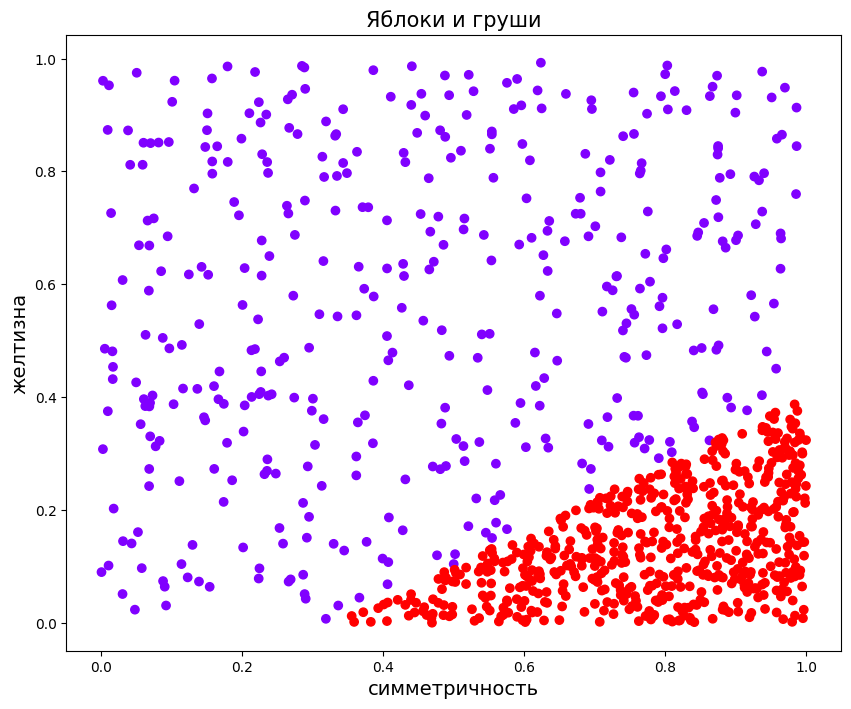

In [34]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [35]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

В модуле torch.nn лежат все необходимые вещи для конструирования нейронок, а в модуле torch.optim лежат все необходимые вещи для выбора метода оптимизации нейросети:

In [36]:
import torch
from torch.nn import Linear, Sigmoid

Есть **два пути объявления нейросетей** в PyTorch:  
- ***функциональный (`Functional`);***
- ***последовательный (`Sequential`);***

Рассмотрим второй путь (он чуть более user-friendly) и построим таким способом один нейрон (точно такой же, который мы реализовывали раньше с помощью Numpy):

In [37]:
num_features = X.shape[1]

neuron = torch.nn.Sequential(
    Linear(num_features, out_features=1),
    Sigmoid()
)

In [38]:
neuron

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

Пока что мы просто создали объект класса `Sequential`, который состоит из одного линейного слоя размерности (num_features, 1) и последующего применения сигмоиды. Но уже сейчас его можно применить к объекту (тензору), просто веса в начале инициализирутся случайно и при forward_pass'е мы получим какой-то ответ пока что необученного нейрона:

In [39]:
neuron(torch.autograd.Variable(torch.FloatTensor([1, 1])))

tensor([0.4009], grad_fn=<SigmoidBackward0>)

Предскажем ещё необученным нейроном:

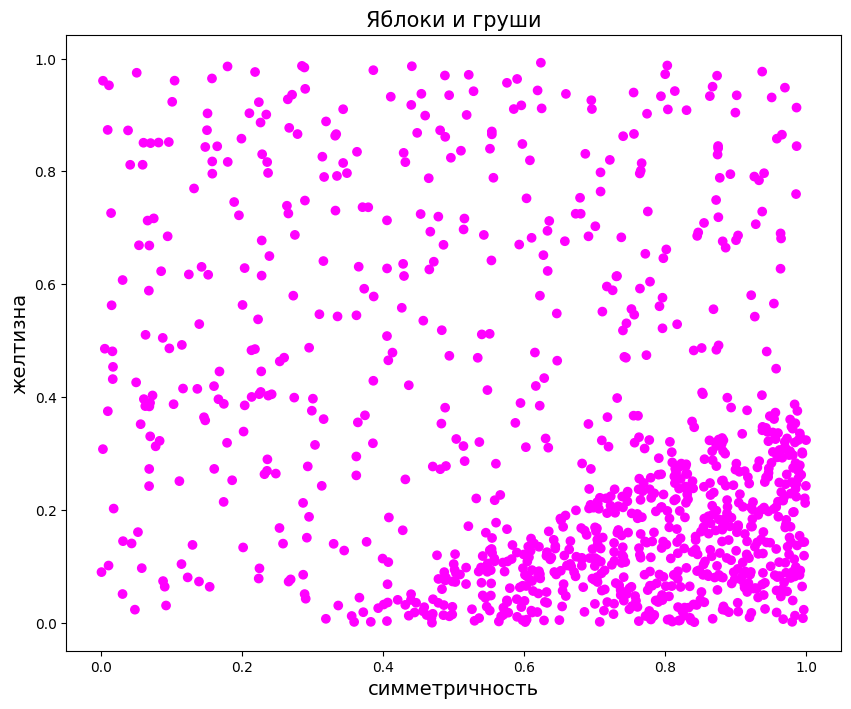

In [40]:
proba_pred = neuron(torch.autograd.Variable(torch.FloatTensor(X)))
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Как и ожидалось, ничего полезного. Давайте научим нейрон отличать груши от яблок по их симметричности и желтизне!

Обернём данные в `torch.Tensor`'ы, а тензоры в `torch.Variable`'ы, чтобы можно было вычислять градиенты по весам:

In [41]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.FloatTensor(y))

Код обучения одного нейрона на PyTorch:

In [43]:
# Квадратичная функция потерь
# Параметр size_average устарел, лучше использовать reduction='mean'
# для автоматического усреднения ошибки по батчу, что делает обучение более стабильным
loss_fn = torch.nn.MSELoss(reduction='mean')

# Увеличил learning_rate с 0.001 до 0.01 для более быстрой сходимости
learning_rate = 0.01

# Заменил метод оптимизации с SGD на Adam, который обычно сходится быстрее
optimizer = torch.optim.Adam(neuron.parameters(), lr=learning_rate)

# Используем scheduler для динамического уменьшения learning_rate
# это помогает сначала быстро сходиться, а потом точно настраивать веса
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

# Ранняя остановка для предотвращения переобучения
best_loss = float('inf')
patience_counter = 0
patience_limit = 20

for t in range(500):
    # Включаем режим обучения
    neuron.train()

    y_pred = neuron(X)

    loss = loss_fn(y_pred, y)

    optimizer.zero_grad()

    loss.backward()

    # Добавил gradient clipping для предотвращения взрыва градиентов
    torch.nn.utils.clip_grad_norm_(neuron.parameters(), max_norm=1.0)

    optimizer.step()

    # Обновляем scheduler
    scheduler.step(loss)

    # ДОБАВЛЕНИЕ: ранняя остановка
    if loss.item() < best_loss:
        best_loss = loss.item()
        patience_counter = 0

        # ДОБАВЛЕНИЕ: сохраняем лучшую модель
        best_model_state = {k: v.cpu().clone() for k, v in neuron.state_dict().items()}
    else:
        patience_counter += 1
        if patience_counter >= patience_limit:
            print(f'Ранняя остановка на эпохе {t}')
            # Восстанавливаем лучшую модель
            neuron.load_state_dict(best_model_state)
            break




# # квадратичная функция потерь (можно сделать другую, например, LogLoss)
# loss_fn = torch.nn.MSELoss(size_average=False)

# # шаг градиентного спуска (точнее -- метода оптимизации)
# learning_rate = 0.001  # == 1e-3
# # сам метод оптимизации нейросети (обычно лучше всего по-умолчанию работает Adam)
# optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
# # итерируемся num_epochs раз, здесь 500
# for t in range(500):
#     # foward_pass() -- применение нейросети (этот шаг ещё называют inference)
#     y_pred = neuron(X)

#     # выведем loss
#     loss = loss_fn(y_pred, y)
#     print('{} {}'.format(t, loss.data))

#     # обнуляем градиенты перед backard_pass'ом (обязательно!)
#     optimizer.zero_grad()

#     # backward_pass() -- вычисляем градиенты loss'а по параметрам (весам) нейросети
#     # этой командой мы только вычисляем градиенты, но ещё не обновляем веса
#     loss.backward()

#     # а тут уже обновляем веса
#     optimizer.step()

Обучили. Предскажем теперь:

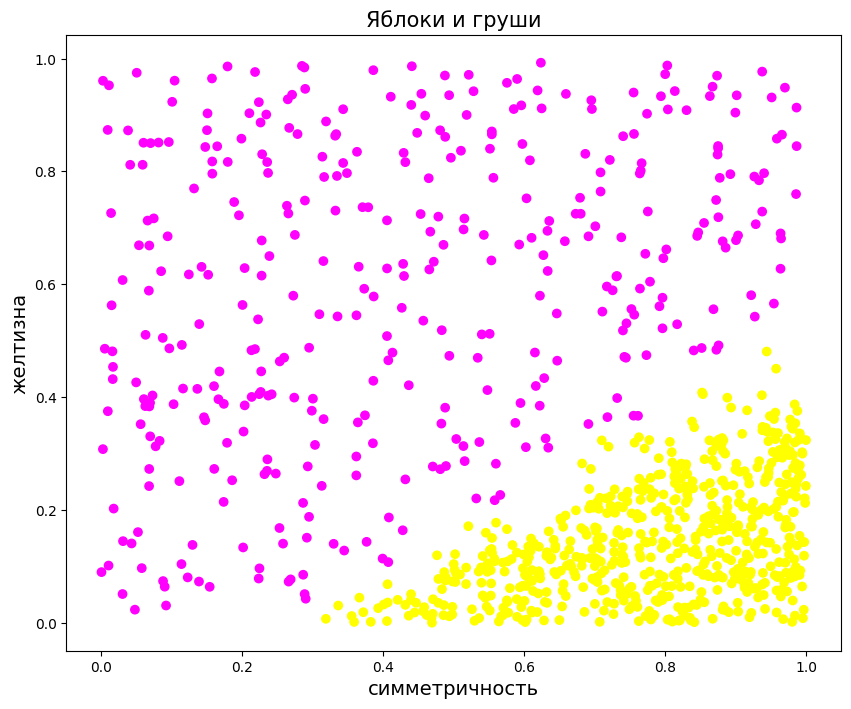

In [44]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Можно добиться лучшего качества работы путём изменения `learning_rate` и количества итераций (возможно, ещё функции потерь и функции активации). Рекомендуем вам поупражняться и использовать функцию потерь `torch.nn.NLLLoss()` или `torch.nn.CrossEntropy()`.

---

Нейрон работет, отличает яблоки от груш. Давайте попробуем более сложную выборку, которая уже не разделяется линейно:

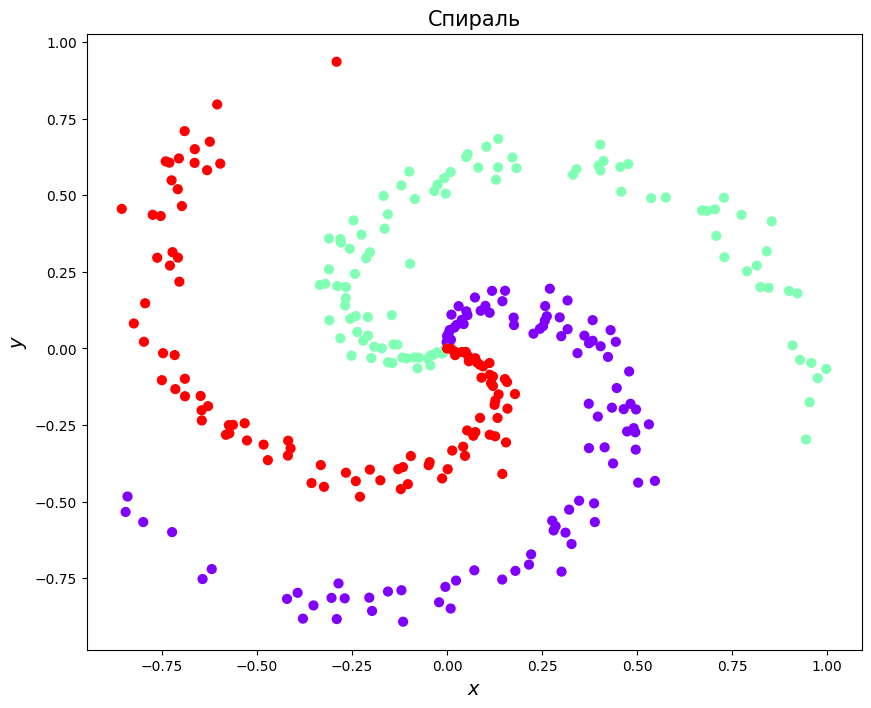

In [45]:
N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)
plt.title('Спираль', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Данные в Variable():

In [46]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.LongTensor(y.astype(np.int64)))

In [47]:
print(X.data.shape, y.data.shape)

torch.Size([300, 2]) torch.Size([300])


Попробуем нейрон с сигмоидой на линейно неразделимой выборке (точнее в данном случае это уже 3 нейрона с софтмаксом):

In [48]:
# N - размер батча (batch_size, нужно для метода оптимизации)
# D_in - размерность входа (количество признаков у объекта)
# D_out - размерность выходного слоя (суть -- количество классов)
N, D_in, D_out = 64, 2, 3

neuron = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),
)

# см. урок по многоклассовой классифкации
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-4
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
for t in range(500):
    # forward
    y_pred = neuron(X)

    # loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # зануляем градиенты с предыдущего шага
    optimizer.zero_grad()

    # backward
    loss.backward()

    # обновляем веса
    optimizer.step()

0 358.47027587890625
1 357.8912353515625
2 357.3173828125
3 356.7488098144531
4 356.1852722167969
5 355.62677001953125
6 355.0732727050781
7 354.5246887207031
8 353.98101806640625
9 353.442138671875
10 352.9079895019531
11 352.3785705566406
12 351.8537292480469
13 351.3335266113281
14 350.8177490234375
15 350.3064880371094
16 349.7996520996094
17 349.29718017578125
18 348.7989807128906
19 348.30499267578125
20 347.8152770996094
21 347.3296813964844
22 346.8481750488281
23 346.3706970214844
24 345.8971862792969
25 345.42767333984375
26 344.9620666503906
27 344.500244140625
28 344.0422058105469
29 343.5879821777344
30 343.1374206542969
31 342.6905212402344
32 342.2472229003906
33 341.80755615234375
34 341.371337890625
35 340.9385986328125
36 340.50933837890625
37 340.08349609375
38 339.66094970703125
39 339.2417297363281
40 338.82574462890625
41 338.41302490234375
42 338.0035095214844
43 337.5971374511719
44 337.19384765625
45 336.79364013671875
46 336.396484375
47 336.0022888183594
48 3

In [49]:
# Обратно в Numpy для отрисовки
X = X.data.numpy()
y = y.data.numpy()

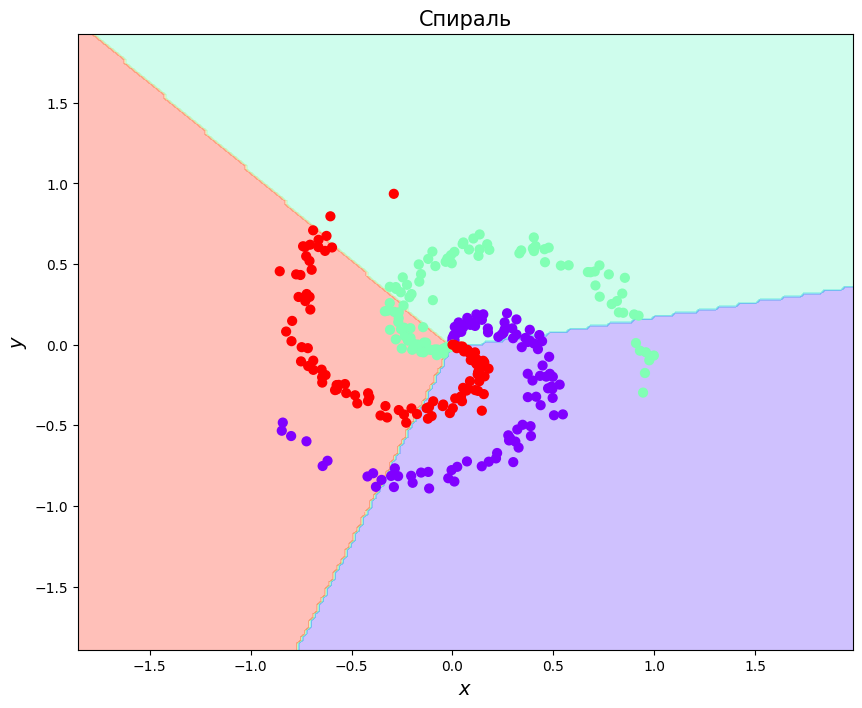

In [50]:
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = neuron(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Спираль', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Не слищком впечатляет. В следующей практике мы попробуем многослойную нейросеть на этой же задаче.

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). *Курс Стэнфорда:  http://cs231n.github.io/*  

3). Практически исчерпывающая информация по основам нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/neural-networks-1/,  
http://cs231n.github.io/neural-networks-2/,  
http://cs231n.github.io/neural-networks-3/,  
http://cs231n.github.io/neural-networks-case-study/#linear

4). *Хорошие статьи по основам нейросетей (на английском):  http://neuralnetworksanddeeplearning.com/chap1.html*

5). *Наглядная демонстрация того, как обучаются нейросети:  https://cs.stanford.edu/people/karpathy/convnetjs/*